In [1]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

from WISE_tools import plot_confusion_matrix

%matplotlib inline

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
timescale_df = pd.read_csv('timescales.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
len(joined),joined.columns

(6484,
 Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
        'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
        'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
        'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
        'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
        'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
        'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
        'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'Unnamed: 0_x',
        'CommonName_y', 'Class', 'CoarseClass', 'IsBinary', 'Unnamed: 0_y',
        'WISE_Designation_x', 'N_obs', 'W1chi2', 'W1chi2red', 'W1_MAD',
        'W1_EWM', 'W2chi2', 'W2chi2red', 'W2_MAD', 'W2_EWM', 'W1-W2chi2',
        'W1-W2chi2red', 'W1-W2_MAD', 'W1-W2_EWM', 'Unnamed: 0',
        'WISE_Designation_y', 'N_visits', 'W1_Nzeroes', 'W1_meanDt', 'W1_stdDt',
        'W2_Nzeroes', 'W2_

In [3]:
training_indices = np.array([c not in np.array(['Misc. Variable','Unknown/Candidate']) 
 for c in joined['Class'].values]) & np.array([i == 0 for i in joined['IsBinary'].values]) & (joined['J-H'] < 2)
training_data = joined[training_indices].fillna(0).reset_index()

In [4]:
#Our features will be color and G/W1 magnitude.
X = training_data[['M_G','G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_W1','W1chi2red','W2chi2red','W1-W2chi2red',
                   'W1_EWM','W2_EWM','W1-W2_EWM','W1_Nzeroes','W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 'W2_meanDt',
                   'W2_stdDt','W1-W2_Nzeroes', 'W1-W2_meanDt', 'W1-W2_stdDt']]
scaler=StandardScaler()
X_scale = scaler.fit_transform(X)
y = training_data['Class'].values
y_c = training_data['CoarseClass'].values
encoder = LabelEncoder()
encoder_c = LabelEncoder()
y_num = encoder.fit_transform(y)
y_num_c = encoder_c.fit_transform(y_c)

In [5]:
svc = SVC(class_weight='balanced')

param_grid = [{"kernel": ["rbf"], "gamma":np.array([0.01,0.1,1,10,1.0/X_scale.shape[1]]), "C":[0.01,0.1,1,10,100]}, 
              {"kernel": ["sigmoid"], "coef0": np.linspace(0,5,11), "gamma":np.array([0.01,0.1,1,10,1.0/X_scale.shape[1]]), 
               "C":[0.01,0.1,1,10,100]},
              {"kernel": ["linear"], "gamma":np.array([0.01,0.1,1,10,1.0/X_scale.shape[1]]),"C":[0.01,0.1,1,10,100]}]

grid = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=10, error_score=-1e10)
grid.fit(X_scale, y_num)

Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

GridSearchCV(cv=5, error_score=-10000000000.0,
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': array(...04166667]),
                          'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'coef0': array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
                          'gamma': array([ 0.01      ,  0.1       ,  1.        , 10.        ,  0.04166667]),
                          'kernel': ['sigmoid']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                     

In [6]:
best_svc = grid.best_estimator_
print(grid.best_params_)
#These parameters seemed to do really well?
best_svc.C = 10
best_svc.gamma = 0.01

{'C': 1, 'gamma': 0.041666666666666664, 'kernel': 'rbf'}


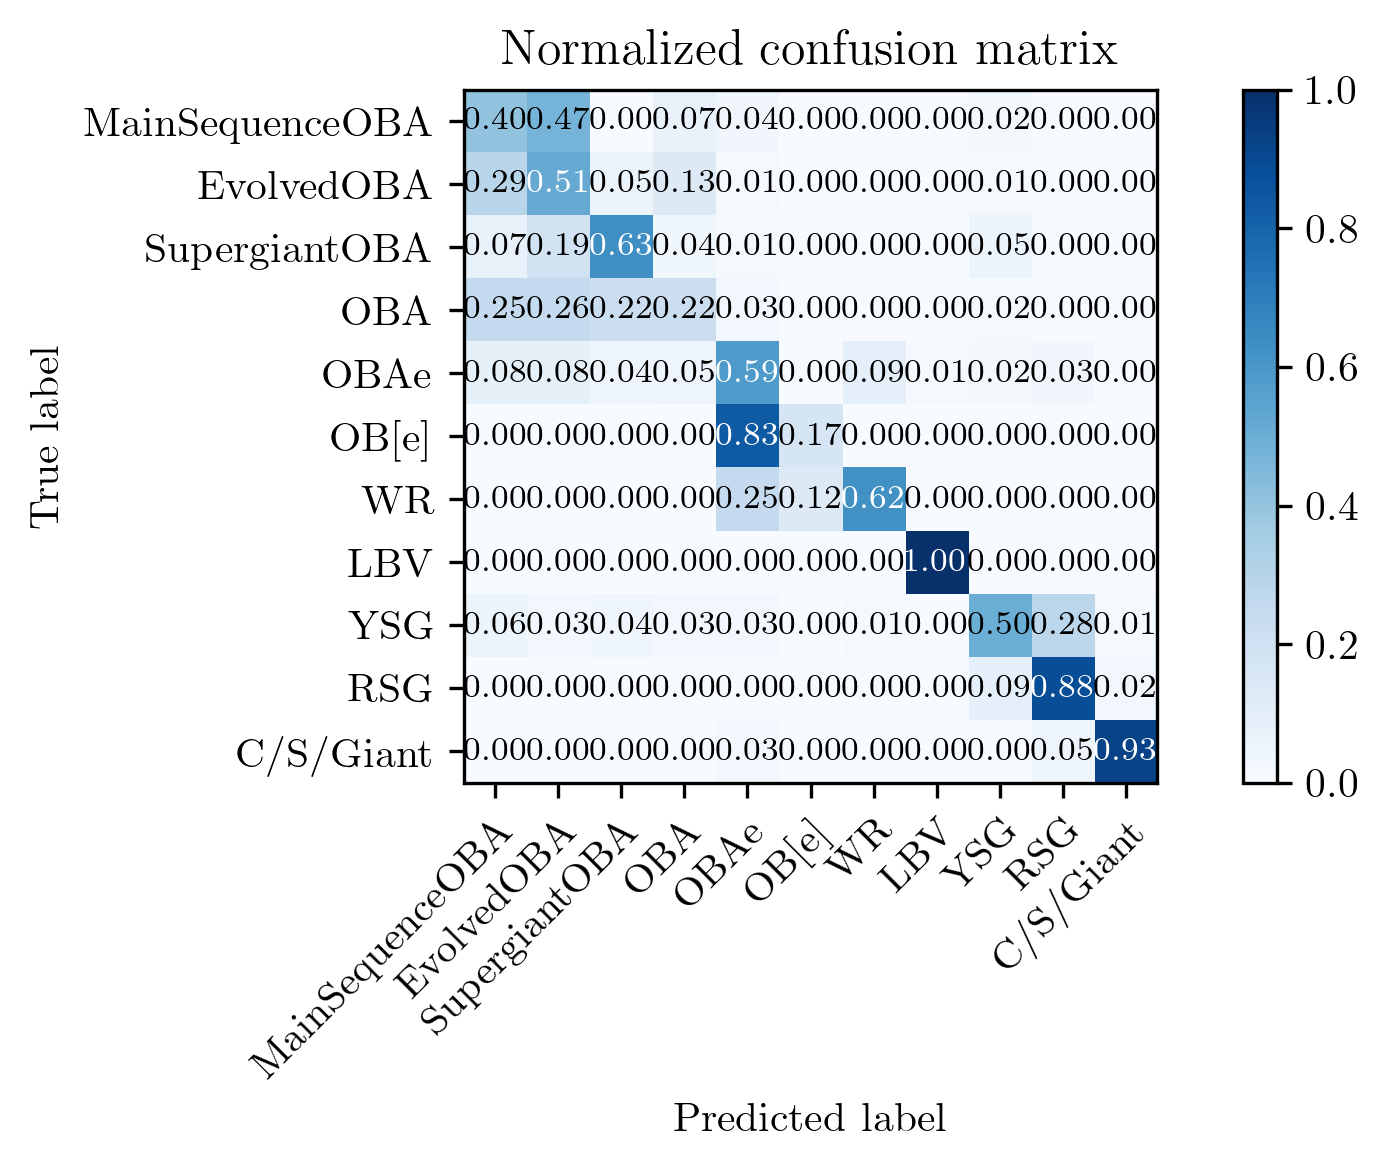

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scale, y_num, test_size=0.3, random_state=0)

best_svc.fit(X_train,y_train)
y_check_SVC = encoder.inverse_transform(best_svc.predict(X_test))

classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBA','OBAe','OB[e]','WR','LBV','YSG',
                   'RSG','C/S/Giant']

fig,ax = plot_confusion_matrix(encoder.inverse_transform(y_test), y_check_SVC, classes=classes, normalize=True);
fig.dpi = 300
plt.tight_layout()
plt.savefig('../plots/confusion_SVC.pdf');

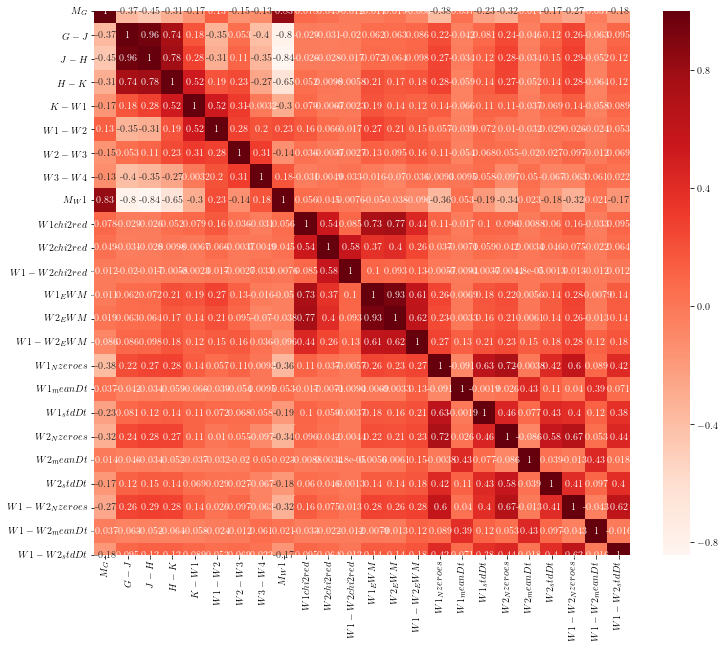

In [23]:
import seaborn as sns
plt.figure(figsize=(12,10))
cor = pd.DataFrame(data=X_scale,columns=X.columns).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds,xticklabels=[f'${col}$' for col in X.columns.values],yticklabels=[f'${col}$' for col in X.columns.values])
plt.show()

(0.5, 5000)

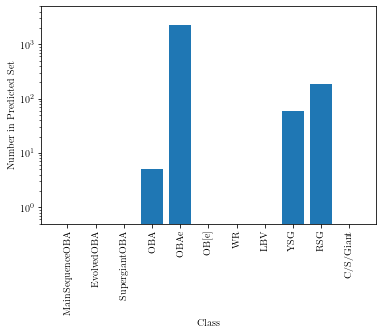

In [8]:
unknown_indices = [c in np.array(['Misc. Variable','Unknown/Candidate']) 
 for c in joined['Class']]
unknowns = joined[unknown_indices].fillna(value=0)
unknowns_data = unknowns[['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1',
                          'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM',
                          'W1-W2_EWM','W1_Nzeroes','W1_meanDt', 'W1_stdDt', 'W2_Nzeroes', 
                          'W2_meanDt', 'W2_stdDt','W1-W2_Nzeroes', 'W1-W2_meanDt', 'W1-W2_stdDt']]
X_unknown = scaler.transform(unknowns_data)
unknown_classes = encoder.inverse_transform(best_svc.predict(unknowns_data))
num_output = []
for pred_class in classes:
    num = len(unknown_classes[unknown_classes == pred_class])
    num_output.append(num)
plt.bar(np.arange(len(classes)),num_output)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(classes)),labels=classes,rotation='vertical')
plt.xlabel('Class')
plt.ylabel('Number in Predicted Set')
plt.ylim(0.5,5000)

In [11]:
def plot_decision_surface(col1,col2,label,rev_yax = True,cm = plt.cm.RdBu_r,cm_bright = ListedColormap(['#FF0000', '#0000FF'])):
    col1_id = np.where(X.columns.values == col1)[0][0]
    col2_id = np.where(X.columns.values == col2)[0][0]
    label_id = encoder.transform([label])[0]
    lens = np.ones(X_scale.shape[1])
    lens[col1_id] = 50
    lens[col2_id] = 50
    list_of_bounding_arrays = [np.linspace(col.min()-0.5, col.max()+0.5, l) if l != 1 else np.array([col.mean()]) 
                               for col,l in zip(X_scale.T,lens)]
    X_grid = np.array([list(tup) for tup in tqdm(itertools.product(*list_of_bounding_arrays))])
    
    X_orig = scaler.inverse_transform(X_grid)
    fig, ax = plt.subplots()
    # Plot the training points
    ax.scatter(scaler.inverse_transform(X_train)[:, col1_id], scaler.inverse_transform(X_train)[:, col2_id], 
               c=np.clip(np.abs(y_train-label_id), 0, 1), cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    ax.scatter(scaler.inverse_transform(X_test)[:, col1_id], scaler.inverse_transform(X_test)[:, col2_id], 
               c=np.clip(np.abs(y_test-label_id), 0, 1), cmap=cm_bright, alpha=0.6, edgecolors='k')
    
    ax.set_xlim(X_orig[:,col1_id].min(), X_orig[:,col1_id].max())
    ax.set_ylim(X_orig[:,col2_id].min(), X_orig[:,col2_id].max())
    if rev_yax:
        ax.invert_yaxis()
    Z = best_svc.decision_function(X_grid)[:,label_id]
    Z = Z.reshape(50,50)
    cf = ax.contourf(np.unique(X_orig[:,col1_id]), np.unique(X_orig[:,col2_id]), Z, cmap=cm, alpha=.5)
    plt.colorbar(mappable=cf)
    return ax

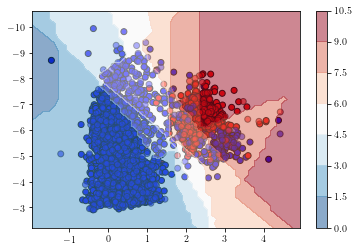

In [12]:
plot_decision_surface('G-J','M_G','RSG')

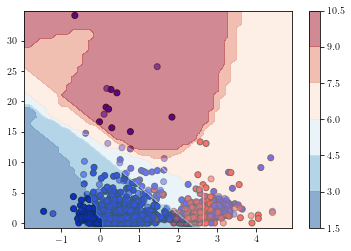

In [13]:
plot_decision_surface('G-J','W1_EWM','RSG',rev_yax=False)

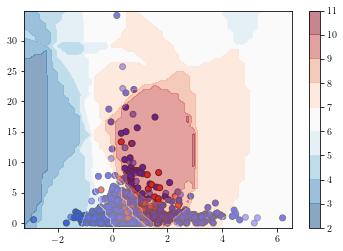

In [14]:
plot_decision_surface('W2-W3','W1_EWM','RSG',rev_yax=False)

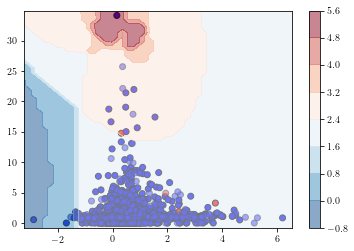

In [15]:
plot_decision_surface('W2-W3','W1_EWM','LBV',rev_yax=False)

# How does this perform with very coarse labels?

In [16]:
grid_c = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=10, error_score=-1e10)
grid_c.fit(X_scale, y_num_c)

Fitting 5 folds for each of 325 candidates, totalling 1625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/Users/carina/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    6.2s
[Parallel(n_jo

GridSearchCV(cv=5, error_score=-10000000000.0,
             estimator=SVC(C=1.0, cache_size=200, class_weight='balanced',
                           coef0=0.0, decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': array(...04166667]),
                          'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'coef0': array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
                          'gamma': array([ 0.01      ,  0.1       ,  1.        , 10.        ,  0.04166667]),
                          'kernel': ['sigmoid']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                     

In [17]:
best_svc_c = grid_c.best_estimator_
print(grid_c.best_params_)
#These parameters seemed to do really well?
#best_svc_c.C = 10
#best_svc_c.gamma = 0.01

{'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}


/Users/carina/Research/UW/GaiaSprintMassive/WISE/code/WISE_tools.py:114: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


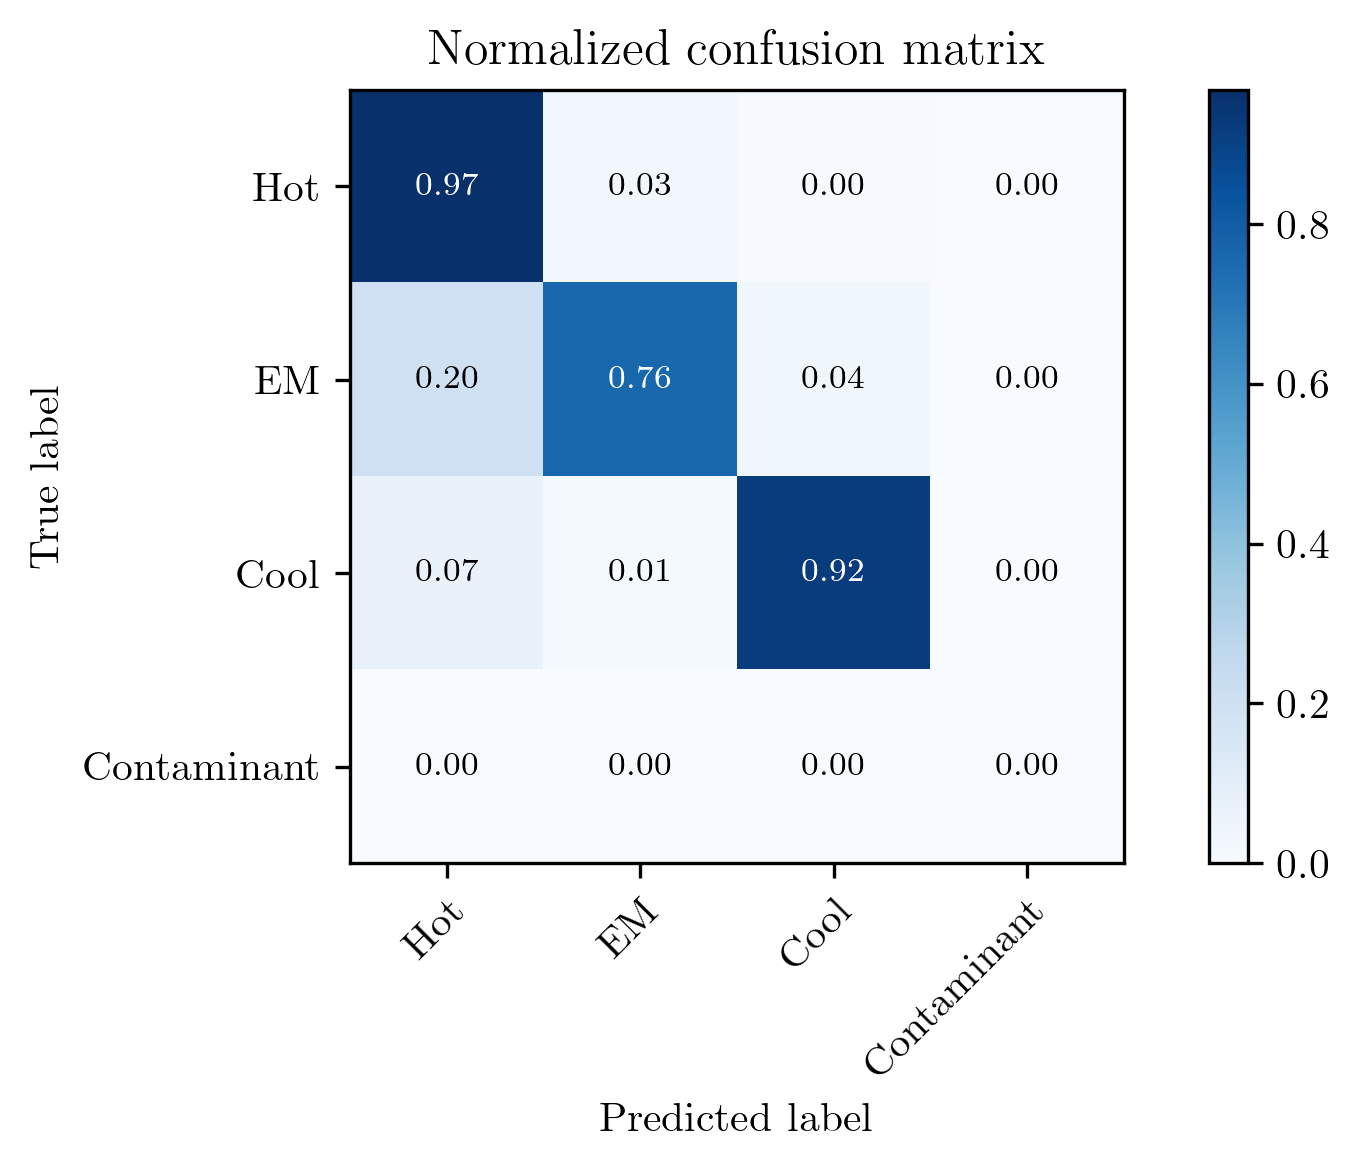

In [25]:
X_train, X_test, y_train_c, y_test_c = train_test_split(
    X_scale, y_num_c, test_size=0.3, random_state=0)

best_svc.fit(X_train,y_train_c)
y_check_SVC_c = encoder_c.inverse_transform(best_svc_c.predict(X_test))

classes_c = ['Hot','EM','Cool','Contaminant']

fig,ax = plot_confusion_matrix(encoder_c.inverse_transform(y_test_c), y_check_SVC_c, classes=classes_c, normalize=True);
fig.dpi = 300
plt.tight_layout()
plt.savefig('confusion_SVC_coarse.pdf');